### Accurate Uncertainties for Deep Learning Using Calibrated Regression
**Anthony Rentsch and Abhimanyu Vasishth**

An implementation and overview of the [2018 paper](https://arxiv.org/abs/1807.00263) by Kuleshov et al.

---

In [1]:
# packages
import pandas as pd
import numpy as np

import scipy.stats as st
import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Overview of the Paper

Accurate uncertainty estimation is an essential aspect of modeling and inference. In a Bayesian framework, these uncertainties are quantified by having a probability distribution over the parameters of the model and integrating over the model weights. Unfortunately, these uncertainties, represented using credible intervals, often do not capture the true data well. For instance, a 95% credible interval for the posterior predictive often fails to capture 95% of the data points in practice. This happens for two primary reasons: model misspecification, which refers to the notion that the parameters of the model may be biased or not expressive enough to assign appropriate probabilities to each credible interval, and dataset shift, which occurs when a model trained on one dataset is asked to create a credible interval for a different dataset. In order to address these concerns, the authors present a set of methods used to recalibrate credible intervals that have been miscalibrated. 

Erroneous uncertainty estimates adversely affect the interpretability of models, especially in the field of deep learning, where models typically overestimate certainty about the predictions they make. Evaluating the quality of uncertainty intervals is challenging as there is no “ground truth” for these intervals. 

Techniques such as Platt scaling are feasible recalibration methods in a classification setting. The major contribution of this paper is to extend these techniques to recalibrate the output of regression models and apply their techniques to time-series forecasting and reinforcement learning. Furthermore, these techniques are applied in a model agnostic manner.

The intuitive idea of calibration in a binary classification setting is that whenever a model assigns a probability 0.9 to an event, this event should occur 90% of the time. In this case, an event is the classification of a point into the positive class (class 1 instead of 0). Furthermore, this should hold true for all probabilities p. To use a concrete example, if a neural network classifies 100 points as class 1, each with probability 0.9, then we would like 90 of these points to actually belong to class 1. This idea extends to regression, where we would like each true point to fall into the 90% confidence interval 90% of the time.

#### Classification

Reproducing figure 2 in the paper by Kuleshov et al.

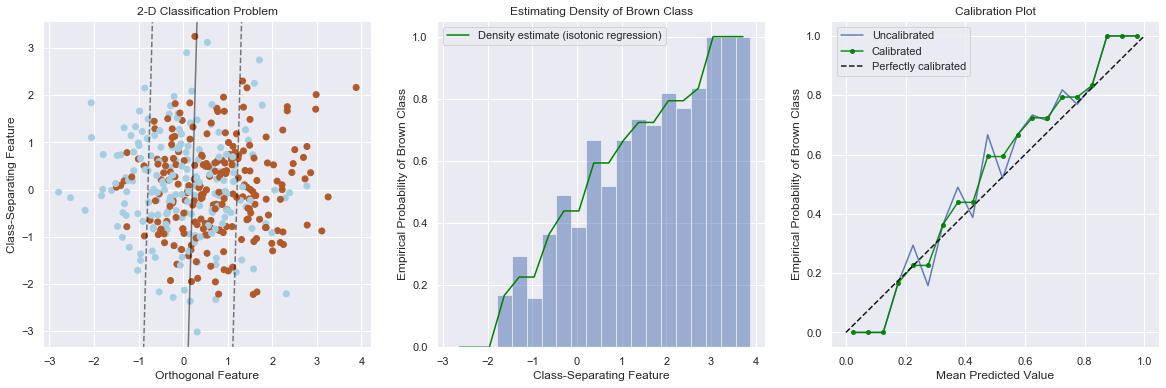

In [2]:
seed = 207
np.random.seed(seed)

npoints=500
X = np.random.normal(size=(npoints,2))
y = np.concatenate((np.ones(shape=(int(npoints/2),)), np.zeros(shape=(int(npoints/2),))), axis=0)
X[:,0] += 0.8*y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size=0.8)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

# Fig 2 Subplot 1
ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.Paired)
ax[0].set_xlabel('Orthogonal Feature')
ax[0].set_ylabel('Class-Separating Feature')
ax[0].set_title('2-D Classification Problem')

# Plotting hyperplane from SVM
clf = svm.SVC(kernel='linear', C=1000, probability=True)
clf.fit(X_train, y_train)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - (clf.intercept_[0]) / w[1]
ax[0].plot(xx,yy, '-', color='black', alpha=0.5)
ax[0].plot(xx+1,yy, '--', color='black', alpha=0.5)
ax[0].plot(xx-1,yy, '--', color='black', alpha=0.5)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

# Fig 2 Subplot 2
X_train_proj = X_train[:,0]

# finding the bins
nbins=20
counts, bins = np.histogram(X_train_proj, bins=nbins)

# finding the ratio of class 1 points in each bin
counts_0, bins_0 = np.histogram(X_train_proj[y_train == 0], bins=bins)
counts_1, bins_1 = np.histogram(X_train_proj[y_train == 1], bins=bins)
ratios = counts_1/(counts_0 + counts_1)

# plotting histograms
bin_means = [0.5*(bins[i] + bins[i+1]) for i in range(nbins)]
bin_width = bins[1]-bins[0]

ax[1].bar(bin_means, ratios, alpha=0.5, width=bin_width)
ax[1].set_xlabel('Class-Separating Feature')
ax[1].set_ylabel('Empirical Probability of Brown Class')
ax[1].set_title('Estimating Density of Brown Class')

# isotonic regression
ir = IsotonicRegression()
density_estimate = ir.fit_transform(bin_means, ratios)
ax[1].plot(bin_means, density_estimate, '-', color='green', label='Density estimate (isotonic regression)')
ax[1].legend();

# Fig 2 Subplot 3
xrange = np.linspace(0+0.5/nbins,1-0.5/nbins,nbins)
ax[2].plot(xrange, ratios, alpha=0.9, label='Uncalibrated')
ax[2].plot(xrange, density_estimate, 'o-', color='green', alpha=0.9, label='Calibrated', markersize=4)
ax[2].plot(np.linspace(0,1), np.linspace(0,1), '--' ,color='black', alpha=0.9, label='Perfectly calibrated')
ax[2].set_xlabel('Mean Predicted Value')
ax[2].set_ylabel('Empirical Probability of Brown Class')
ax[2].set_title('Calibration Plot')
ax[2].legend();

Left: Two classes are separated by a hyperplane in 2D. The x-axis is especially useful for separating the two classes. Middle: We project data onto the x-axis and fit a histogram (blue) or an isotonic regression model (green) to estimate the empirical probability of observing the brown class as a function of x. We may use these probabilities as approximately calibrated predictions. Right: The calibration of the original linear model and its recalibrated version are assessed by binning the predictions into twenty intervals ([0, 0.05],(0.05, 0.1], ...), and plotting the predicted vs. the observed frequency of the brown class in each interval.

#### Regression

Extending the classification case to regression.

In [3]:
# make data
n = 100
X = np.linspace(-3,3,n)

y = X + X**2 + np.random.normal(0,2,size=n) #+ 0.4*X + np.sin(4*X)
# sort for plotting
indices = np.argsort(X.flatten())
X = X[indices]
y = y[indices]
# prepare for statsmodels
X_sm = sm.add_constant(-X**2 - X**4 + 10*X)

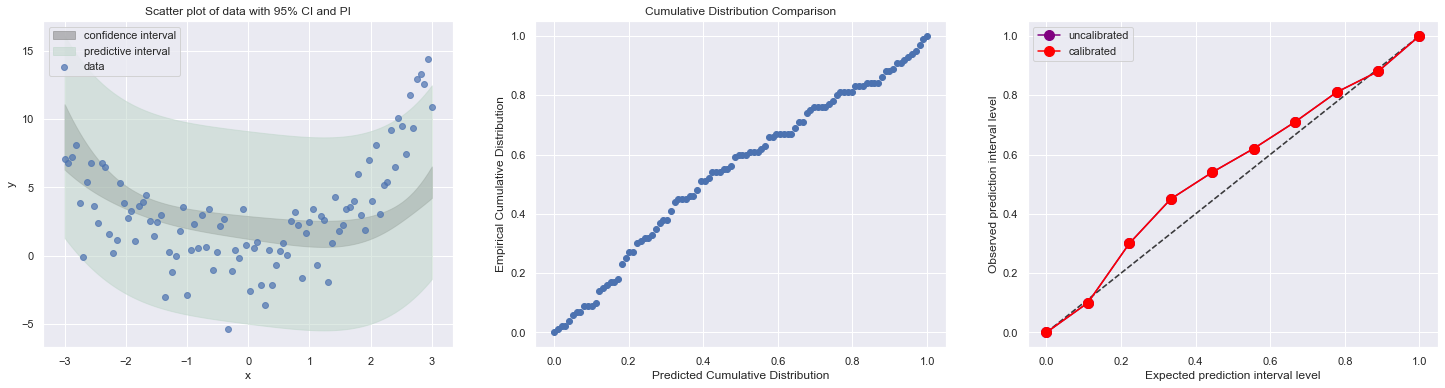

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(25,6))

# Figure 1
model = sm.OLS(y, X_sm).fit()
alpha = .95
fit = model.get_prediction().summary_frame(alpha=(1-alpha))
ax[0].fill_between(X.flatten(), fit['mean_ci_lower'], fit['mean_ci_upper'], 
                color='grey', alpha=0.5, label='confidence interval');
ax[0].fill_between(X.flatten(), fit['obs_ci_lower'], fit['obs_ci_upper'], 
                color='#BDD5C8', alpha=0.5, label='predictive interval')
ax[0].scatter(X.flatten(), y, alpha=0.7, label='data')
ax[0].legend()
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title(f'Scatter plot of data with {int(alpha*100)}% CI and PI')

# Figure 2
alphas = np.linspace(0,1,100)
counts = []
for i, alpha in enumerate(alphas):
    fit = model.get_prediction().summary_frame(alpha=(1-alpha))
    count = fit[(fit['obs_ci_lower'] < y) & (fit['obs_ci_upper'] > y)].shape[0]
    counts.append(count/n)
ax[1].plot(alphas, counts, 'o')
ax[1].set_xlabel('Predicted Cumulative Distribution')
ax[1].set_ylabel('Empirical Cumulative Distribution')
ax[1].set_title('Cumulative Distribution Comparison')

# Figure 3
alphas = np.linspace(0,1,10)
uncalibrated_props = []
for i, alpha in enumerate(alphas):
    fit = model.get_prediction().summary_frame(alpha=(1-alpha))
    count = fit[(fit['obs_ci_lower'] < y) & (fit['obs_ci_upper'] > y)].shape[0]
    uncalibrated_props.append(count/n)
ir = IsotonicRegression()
calibrated_props = ir.fit_transform(alphas, uncalibrated_props)
ax[2].plot([(0,0), (1,1)], color='black', linestyle='dashed', alpha=0.5)
ax[2].plot(alphas, uncalibrated_props, marker='o', markersize=10, linestyle='solid', color='purple', 
           label='uncalibrated')
ax[2].plot(alphas, calibrated_props, marker='o', markersize=10, linestyle='solid', color='red', 
           label='calibrated')
ax[2].legend()
ax[2].set_xlabel('Expected prediction interval level')
ax[2].set_ylabel('Observed prediction interval level');

Figure 3. Calibrated regression. Left: A Linear Regression model outputs probabilistic forecasts The confidence intervals do not always represent the true frequency of the prediction falling in the interval. Middle: For each credible interval, we plot the observed number of times the prediction falls in the interval. We fit this function and use it to output the actual probability of any given interval. Right: Forecast calibration can be assessed by plotting expected vs. empirical rates of observing an outcome. 

---